
# Model Analysis
This script combines traditional machine learning models and transformer-based models to classify IT tickets and evaluate the performance of each model.
The process includes data loading, preprocessing, model training, and evaluation.

Created by: Adam Blank\
Professor: Zohaib Khawaja\
Fall 2024

In [1]:
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import gc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    AdamW, 
    get_linear_schedule_with_warmup
)
import re
import os

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Device Configuration
Check if CUDA is available and set the device accordingly. Configure XGBoost for GPU if available.

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print(f"Using device: {torch.cuda.get_device_name(0)}")
    xgb_gpu_params = {
        'predictor': 'gpu_predictor'
    }
else:
    print("CUDA is not available. Using CPU instead.")
    device = torch.device("cpu")
    xgb_gpu_params = {}

Using device: NVIDIA GeForce RTX 3090


# Data Loading and Preprocessing
Load the CSV file and preprocess the data by cleaning text fields, filling missing values, and encoding labels.

In [3]:
print("Loading CSV...")
df = pd.read_csv('dataframe.csv')

# Examine data structure
print("\nDataframe Info:")
print(df.info())

print("\nSample of raw data:")
print(df.head())

print("\nMissing values:")
print(df.isnull().sum())

print("\nUnique values in IT Group:")
print(df['fields.customfield_15404.value'].value_counts())

# Text cleaning function
def clean_text(text):
    if pd.isna(text):
        return ''
    text = str(text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = ' '.join(text.split())
    return text.lower()

# Clean text fields
print("Cleaning text fields...")
df['fields.summary'] = df['fields.summary'].apply(clean_text)
df['fields.description'] = df['fields.description'].apply(clean_text)

print("Cleaning Data...")
df = df[[
    'fields.customfield_14201',
    'fields.assignee.displayName',
    'fields.customfield_15404.value',
    'fields.summary',
    'fields.description'
]]

print("Renaming Columns...")
df = df.rename(columns={
    'fields.customfield_14201': 'Category 1',
    'fields.assignee.displayName': 'Assignee',
    'fields.customfield_15404.value': 'IT Group',
    'fields.summary': 'Summary',
    'fields.description': 'Description'
})

print("Filling NaN values...")
imputer = SimpleImputer(strategy='constant', fill_value='unknown')
df[['IT Group', 'Assignee', 'Category 1']] = imputer.fit_transform(df[['IT Group', 'Assignee', 'Category 1']])

print("Combining Summary and Description...")
df['combined'] = df[['Summary', 'Description']].fillna('').agg(' '.join, axis=1)

print("Encoding Labels...")
le_it_group = LabelEncoder()
df['IT Group'] = le_it_group.fit_transform(df['IT Group'])

# Ensure consecutive class labels
unique_classes = np.sort(df['IT Group'].unique())
class_mapping = {old: new for new, old in enumerate(unique_classes)}
df['IT Group'] = df['IT Group'].map(class_mapping)

print("Unique classes after remapping:", sorted(df['IT Group'].unique()))

Loading CSV...

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322600 entries, 0 to 322599
Data columns (total 38 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   expand                                      322600 non-null  object 
 1   id                                          322600 non-null  int64  
 2   self                                        322600 non-null  object 
 3   key                                         322600 non-null  object 
 4   fields.summary                              322599 non-null  object 
 5   fields.customfield_14201                    321899 non-null  object 
 6   fields.description                          260753 non-null  object 
 7   fields.project.self                         322600 non-null  object 
 8   fields.project.id                           322600 non-null  int64  
 9   fields.project.key                    

# Balancing the Dataset
Create a balanced dataset by sampling an equal number of instances from each class.


Creating balanced dataset for baseline model...

Original class distribution:
IT Group
26    117454
41     49929
33     34759
14     29942
13     18326
36     16842
3       8997
1       8326
21      6691
34      5368
2       4787
28      4224
16      2529
39      2412
37      1792
24      1617
25      1349
29      1259
18       896
19       860
7        821
5        631
40       623
12       600
27       480
8        441
15       150
22       122
10       118
4        104
23        47
17        34
11        23
35        21
0          8
9          6
31         3
6          3
32         2
30         2
20         1
38         1
Name: count, dtype: int64


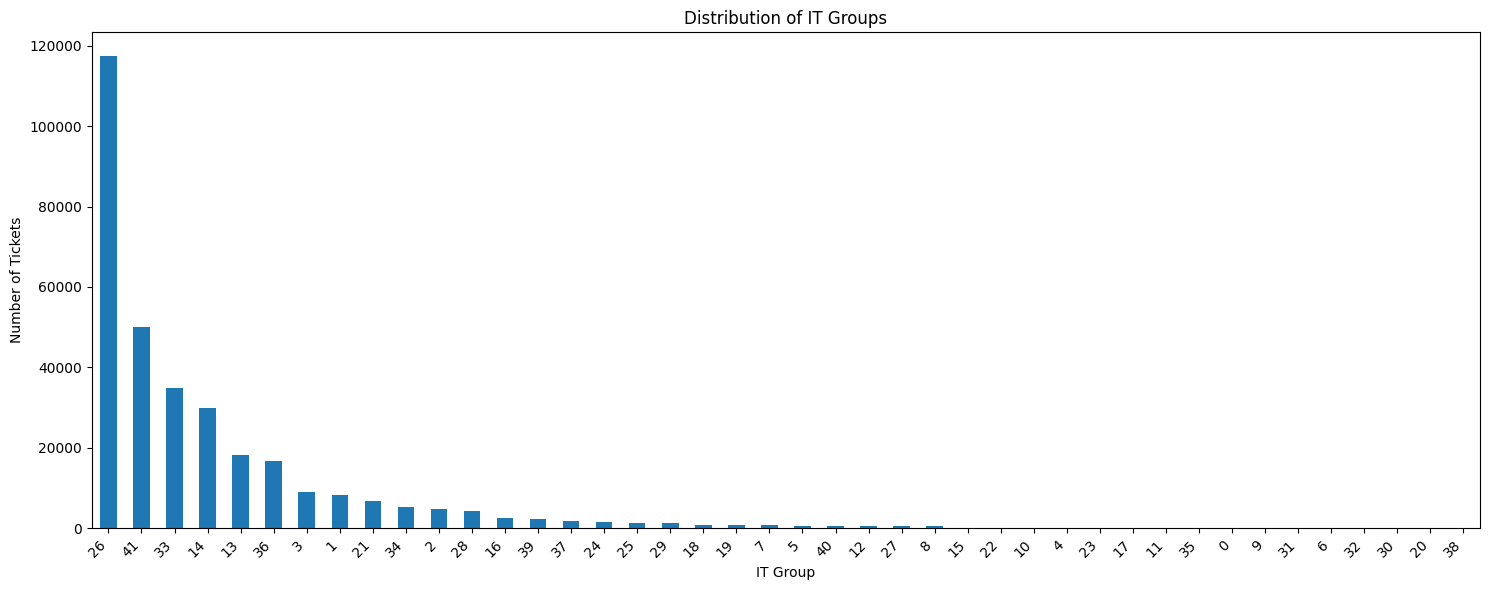


Removed 18 classes with fewer than 500 samples

Final balanced dataset statistics:
Total samples: 11982

Samples per class:
IT Group
5     504
26    500
33    500
41    500
13    500
36    500
3     500
14    500
1     500
21    500
2     500
34    500
16    500
39    500
37    500
28    500
24    500
25    500
18    500
29    500
19    500
7     500
40    498
12    480
Name: count, dtype: int64


In [4]:
print("\nCreating balanced dataset for baseline model...")
group_counts = df['IT Group'].value_counts()
min_acceptable_samples = 500
print(f"\nOriginal class distribution:")
print(group_counts)

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
df['IT Group'].value_counts().plot(kind='bar')
plt.title('Distribution of IT Groups')
plt.xlabel('IT Group')
plt.ylabel('Number of Tickets')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

valid_groups = group_counts[group_counts >= min_acceptable_samples].index
df_filtered = df[df['IT Group'].isin(valid_groups)]
print(f"\nRemoved {len(group_counts) - len(valid_groups)} classes with fewer than {min_acceptable_samples} samples")

balanced_dfs = []
samples_per_class = min_acceptable_samples
for group in valid_groups:
    group_df = df_filtered[df_filtered['IT Group'] == group]
    if len(group_df) < samples_per_class * 1.5:
        n_samples = int(len(group_df) * 0.8)
    else:
        n_samples = samples_per_class
    sampled_df = group_df.sample(n=n_samples, random_state=42)
    balanced_dfs.append(sampled_df)

df_balanced = pd.concat(balanced_dfs, ignore_index=True)

print("\nFinal balanced dataset statistics:")
print(f"Total samples: {len(df_balanced)}")
print("\nSamples per class:")
print(df_balanced['IT Group'].value_counts())

df = df_balanced
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Traditional Machine Learning Models
Train and evaluate traditional ML models like RandomForest, XGBoost, Logistic Regression, Naive Bayes, and Linear SVC.

In [5]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
print("Splitting Data...")
X_train, X_test, y_train, y_test = train_test_split(df['combined'], df['IT Group'], test_size=0.2, random_state=42)

print("Remapping labels to consecutive integers...")
unique_labels = sorted(set(y_train) | set(y_test))
label_map = {label: idx for idx, label in enumerate(unique_labels)}
y_train = pd.Series(y_train).map(label_map).values
y_test = pd.Series(y_test).map(label_map).values

print("Unique labels after remapping:")
print("Train:", sorted(np.unique(y_train)))
print("Test:", sorted(np.unique(y_test)))

pipelines = {
    'RandomForest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))
    ]),
    'XGBoost': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)),
        ('clf', XGBClassifier(
            n_jobs=-1, 
            random_state=42,
            objective='multi:softmax',
            num_class=len(np.unique(y_train)),
            tree_method='hist',
            **xgb_gpu_params
        ))
    ]),
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', LogisticRegression(max_iter=1000, n_jobs=-1))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', MultinomialNB())
    ]),
    'Linear SVC': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=10000)), 
        ('clf', LinearSVC(random_state=42, max_iter=10000))
    ])
}

results = {}
for name, pipeline in pipelines.items():
    print(f"\nTraining {name} model...")
    pipeline.fit(X_train, y_train)
    
    print(f"Making predictions with {name}...")
    y_pred = pipeline.predict(X_test)
    
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred)
    }

Splitting Data...
Remapping labels to consecutive integers...
Unique labels after remapping:
Train: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]
Test: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20), np.int64(21), np.int64(22), np.int64(23)]

Training RandomForest model...
Making predictions with RandomForest...

Training XGBoost model...


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [20:15:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "predictor" } are not used.

  warnings.warn(smsg, UserWarning)


Making predictions with XGBoost...

Training Logistic Regression model...
Making predictions with Logistic Regression...

Training Naive Bayes model...
Making predictions with Naive Bayes...

Training Linear SVC model...
Making predictions with Linear SVC...


# Transformer-Based Models
Train and evaluate transformer models like BERT and RoBERTa for text classification.

In [6]:
def transformer_classification(df, model_name, max_len=256, batch_size=4, epochs=3, accumulation_steps=4):
    le = LabelEncoder()
    labels = le.fit_transform(df['IT Group'])
    num_classes = len(np.unique(labels))
    
    texts = df['combined'].tolist()
    
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.2, random_state=42
    )
    
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, 
        num_labels=num_classes
    ).to(device)
    
    if hasattr(model, 'gradient_checkpointing_enable'):
        model.gradient_checkpointing_enable()
    
    train_encodings = tokenizer(
        X_train, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    test_encodings = tokenizer(
        X_test, 
        truncation=True, 
        padding=True, 
        max_length=max_len
    )
    
    train_dataset = torch.utils.data.TensorDataset(
        torch.tensor(train_encodings['input_ids']),
        torch.tensor(train_encodings['attention_mask']),
        torch.tensor(y_train)
    )
    test_dataset = torch.utils.data.TensorDataset(
        torch.tensor(test_encodings['input_ids']),
        torch.tensor(test_encodings['attention_mask']),
        torch.tensor(y_test)
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False
    )
    
    optimizer = AdamW(model.parameters(), lr=5e-5)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    
    model.train()
    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        progress_bar = tqdm(train_loader, desc=f"Training", leave=True)
        total_loss = 0
        batch_losses = []
        optimizer.zero_grad()
        
        for batch_idx, batch in enumerate(progress_bar):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(
                input_ids, 
                attention_mask=attention_mask, 
                labels=labels
            )
            loss = outputs.loss / accumulation_steps
            total_loss += loss.item() * accumulation_steps
            batch_losses.append(loss.item() * accumulation_steps)
            
            loss.backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()
                
                progress_bar.set_postfix({
                    'loss': f"{sum(batch_losses[-accumulation_steps:]) / accumulation_steps:.4f}",
                    'avg_loss': f"{total_loss/(batch_idx+1):.4f}"
                })
                
                del outputs
                torch.cuda.empty_cache()
        
        epoch_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} completed - Average Loss: {epoch_loss:.4f}")
    
    print("\nEvaluating model...")
    model.eval()
    predictions, true_labels = [], []
    eval_progress = tqdm(test_loader, desc="Evaluating")
    
    with torch.no_grad():
        for batch in eval_progress:
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            
            outputs = model(input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            eval_progress.set_postfix({
                'batch_size': input_ids.size(0)
            })
    
    print(f"\n--- {model_name} Performance ---")
    print(classification_report(true_labels, predictions))
    
    return {
        'model': model,
        'tokenizer': tokenizer,
        'label_encoder': le,
        'predictions': predictions,
        'true_labels': true_labels
    }

print("\nTraining Transformer Models...")
transformer_models = [
    'bert-base-uncased',
    'roberta-base'
]

transformer_results = {}
for model_name in transformer_models:
    print(f"\n--- Training {model_name} ---")
    try:
        transformer_results[model_name] = transformer_classification(
            df, 
            model_name, 
            max_len=256, 
            batch_size=4, 
            epochs=3,
            accumulation_steps=4
        )
    except Exception as e:
        print(f"Error training {model_name}: {e}")


Training Transformer Models...

--- Training bert-base-uncased ---


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:36<00:00, 15.35it/s, loss=0.7942, avg_loss=1.5515]


Epoch 1/3 completed - Average Loss: 1.5510

Epoch 2/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:37<00:00, 15.22it/s, loss=1.1745, avg_loss=0.7663]


Epoch 2/3 completed - Average Loss: 0.7660

Epoch 3/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:37<00:00, 15.25it/s, loss=0.5557, avg_loss=0.5427]


Epoch 3/3 completed - Average Loss: 0.5425

Evaluating model...


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:10<00:00, 58.08it/s, batch_size=1]



--- bert-base-uncased Performance ---
              precision    recall  f1-score   support

           0       0.80      0.83      0.82        94
           1       0.63      0.71      0.67       112
           2       0.69      0.84      0.76       105
           3       0.84      0.84      0.84       108
           4       0.83      0.87      0.85        98
           5       0.87      0.85      0.86        88
           6       0.89      0.94      0.92       103
           7       0.56      0.13      0.21       108
           8       0.87      0.92      0.90        93
           9       0.77      0.81      0.79        98
          10       0.95      0.88      0.91       105
          11       0.60      0.49      0.54        92
          12       0.61      0.72      0.66       108
          13       0.82      0.86      0.84        94
          14       0.60      0.37      0.46       100
          15       0.81      0.74      0.77       104
          16       0.51      0.89      0.6

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(



Epoch 1/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:38<00:00, 15.14it/s, loss=0.8239, avg_loss=1.4921]


Epoch 1/3 completed - Average Loss: 1.4915

Epoch 2/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:38<00:00, 15.13it/s, loss=1.1445, avg_loss=0.8895]


Epoch 2/3 completed - Average Loss: 0.8891

Epoch 3/3


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2397/2397 [02:38<00:00, 15.12it/s, loss=1.1101, avg_loss=0.6818]


Epoch 3/3 completed - Average Loss: 0.6820

Evaluating model...


Evaluating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 600/600 [00:09<00:00, 66.08it/s, batch_size=1]



--- roberta-base Performance ---
              precision    recall  f1-score   support

           0       0.79      0.82      0.81        94
           1       0.64      0.67      0.66       112
           2       0.81      0.78      0.80       105
           3       0.82      0.90      0.85       108
           4       0.89      0.83      0.86        98
           5       0.79      0.86      0.83        88
           6       0.93      0.89      0.91       103
           7       0.37      0.10      0.16       108
           8       0.89      0.91      0.90        93
           9       0.78      0.77      0.77        98
          10       0.87      0.87      0.87       105
          11       0.46      0.70      0.55        92
          12       0.57      0.61      0.59       108
          13       0.76      0.87      0.81        94
          14       0.58      0.38      0.46       100
          15       0.78      0.74      0.76       104
          16       0.52      0.93      0.67    

Save the trained transformer models to disk.

In [7]:
for name, result in transformer_results.items():
    model_path = f'{name}_model.pth'
    torch.save(result['model'].state_dict(), model_path)
    print(f"Saved {name} model to {model_path}")

Saved bert-base-uncased model to bert-base-uncased_model.pth
Saved roberta-base model to roberta-base_model.pth


Display model performance and compare them.


Model Performance Comparison:
                 Model      Model Type  Accuracy
5    bert-base-uncased     Transformer  0.759700
6         roberta-base     Transformer  0.743846
2  Logistic Regression  Traditional ML  0.738006
4           Linear SVC  Traditional ML  0.734668
1              XGBoost  Traditional ML  0.717146
3          Naive Bayes  Traditional ML  0.703379
0         RandomForest  Traditional ML  0.699625


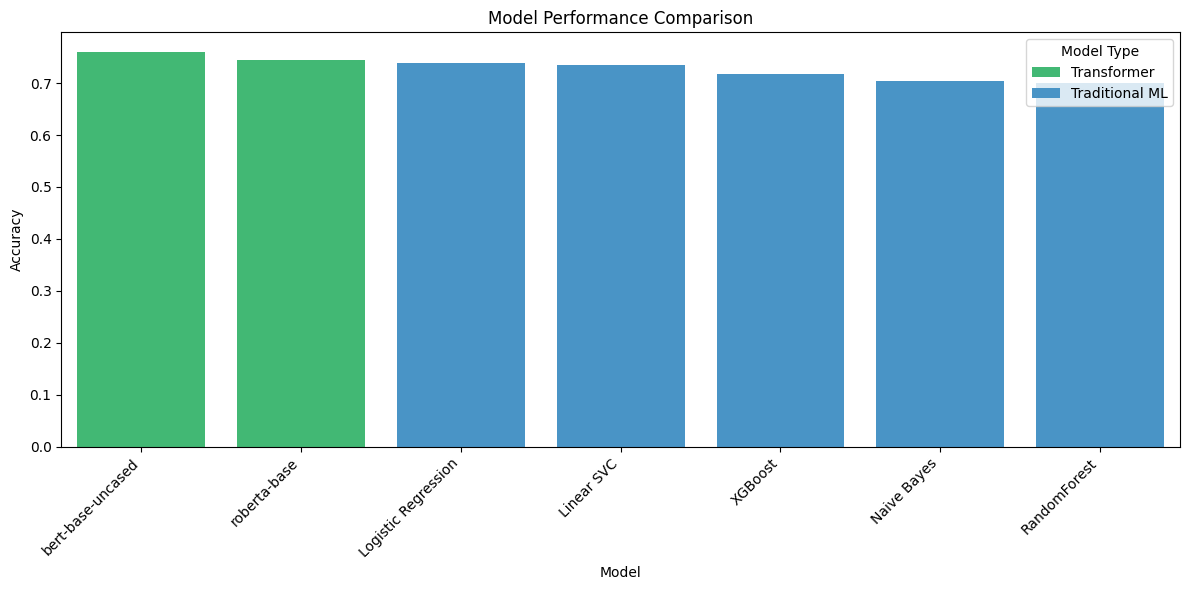


Detailed Classification Reports:

RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.76        94
           1       0.76      0.57      0.65       112
           2       0.79      0.81      0.80       105
           3       0.85      0.81      0.83       108
           4       0.72      0.81      0.76        98
           5       0.81      0.82      0.81        88
           6       0.79      0.84      0.82       103
           7       0.45      0.21      0.29       108
           8       0.82      0.92      0.87        93
           9       0.71      0.71      0.71        98
          10       0.88      0.82      0.85       105
          11       0.39      0.50      0.44        92
          12       0.59      0.54      0.56       108
          13       0.76      0.81      0.78        94
          14       0.45      0.53      0.49       100
          15       0.57      0.74      0.64       104
          

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine results from both traditional ML and transformer models
all_results = {}

# Add traditional ML results
for name, result in results.items():
    all_results[name] = {
        'accuracy': result['accuracy'],
        'classification_report': result['classification_report'],
        'model_type': 'Traditional ML'
    }

# Add transformer results
for name in transformer_results:
    # Extract accuracy from the last evaluation metrics
    true_labels = transformer_results[name]['true_labels']
    predictions = transformer_results[name]['predictions']
    
    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    
    all_results[name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'model_type': 'Transformer'
    }

# Create a DataFrame for visualization
performance_df = pd.DataFrame({
    'Model': list(all_results.keys()),
    'Accuracy': [all_results[name]['accuracy'] for name in all_results],
    'Model Type': [all_results[name]['model_type'] for name in all_results]
})

# Sort by accuracy
performance_df = performance_df.sort_values('Accuracy', ascending=False)

# Display the DataFrame
print("\nModel Performance Comparison:")
print(performance_df[['Model', 'Model Type', 'Accuracy']])

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=performance_df,
    x='Model',
    y='Accuracy',
    hue='Model Type',
    palette=['#2ecc71', '#3498db']
)

plt.title('Model Performance Comparison')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Display detailed classification reports
print("\nDetailed Classification Reports:")
for name in all_results:
    print(f"\n{name} Classification Report:")
    print(all_results[name]['classification_report']) 
# %%